In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import GenParamTuple# candidate_environments_args["n_environments"] = 50


np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

## Make true environment

In [27]:
# 0. Setup
N, M = 7,7



# Start by making the agent we want to learn the parameters of
agent_gamma = 0.7
p_true=0.9

agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 0.1
agent_R[N-1, M-1] = 0.8
agent_R = agent_R.flatten()

goal_states = np.where(agent_R != 0)[0]


wall_states = [14] #TODO: why do we need this

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


#Define custom functions to generate reward, transition and gamma.
def custom_transition_func(*p):

    _T = transition_matrix(N=7, M=7, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = 0.1
    reward_func[N-1, M-1] = big_reward
    return reward_func.flatten()


#Create parameter ranges
resolution = 15
p_range = np.linspace(0.5, 0.95, resolution)
gamma_range = np.linspace(0.5, 0.95, resolution)
R_range = np.linspace(0.1, 1, resolution)


gamma_range = gamma_range.reshape(1, resolution)
p_range = p_range.reshape(1, resolution)
R_range = R_range.reshape(1, resolution)



true_params = GenParamTuple(T = T_True, gamma=agent_gamma, R=agent_R)




big_small = Environment(
    N=N,
    M=M,
    reward_function = custom_reward_func,
    transition_function=custom_transition_func,
    gamma = custom_gamma_func,
    wall_states=wall_states,
    start_state=0,
    goal_states=goal_states
)

In [28]:
env_design = EnvironmentDesign(base_environment=big_small, 
                               user_params=true_params, 
                               learn_what = ["gamma", "R"],
                               parameter_ranges_R=R_range,
                               parameter_ranges_gamma=gamma_range,
                               parameter_ranges_T=None)

Generated parameter mesh of shape:  (15, 15)


In [29]:
candidate_environments_args = {}
candidate_environments_args["generate_how"] = "entropy_BM"
candidate_environments_args["n_compute_BM"] = 20
candidate_environments_args["n_iterations_gradient"] = 15
candidate_environments_args["stepsize_gradient"] = 0.001


env_design.run_n_episodes(n_episodes = 15,
                          candidate_environments_args=candidate_environments_args,
                          verbose=True)

Started episode 0.
Finished episode 0.
Started episode 1.
Beginning calculation of log-likelihood. Calculating 225 samples.


ValueError: setting an array element with a sequence.

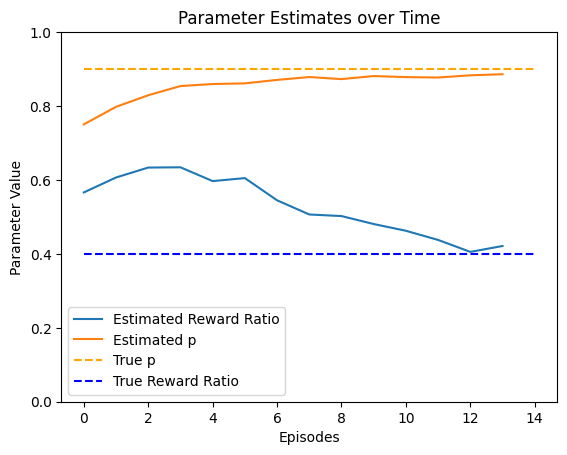

In [8]:
params = env_design.diagnostics["parameter_means"]
params = np.array(params)

import matplotlib.pyplot as plt

plt.plot(params[:, 0], label="Estimated Reward Ratio")
plt.plot(params[:, 1], label="Estimated p")
plt.hlines(p_true, 0, params.shape[0], color="orange", linestyle="--", label="True p")
plt.hlines(0.4, 0, params.shape[0], color="blue", linestyle="--", label="True Reward Ratio")
plt.ylim(0,1)
plt.title("Parameter Estimates over Time")
plt.xlabel("Episodes")
plt.ylabel("Parameter Value")
plt.legend()